In [1]:
import os
import re
import io
import sys
import glob
import h5py
import numpy as np
import pandas as pd

import pickle
from scipy import stats
from scipy import optimize
from scipy import interpolate

from collections import namedtuple
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab

import activity_manager as AM
import convert_to_csv as to_csv

%load_ext autoreload
%autoreload 2

# plot configuration
params = {
    'legend.fontsize': 10,
    'figure.figsize': (10, 8),
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
}
pylab.rcParams.update(params)

%matplotlib inline

FIG_DIR = '../talk/img/'
SAVE_FIG_FLAG = False

In [3]:
%matplotlib --list
%matplotlib inline

Available matplotlib backends: ['osx', 'inline', 'ipympl', 'wx', 'notebook', 'agg', 'qt5', 'nbagg', 'tk', 'qt', 'qt4', 'gtk3', 'gtk']


In [ ]:
dirname = r'E:\Dropbox\_running-cycling\data\strava_data\activities_2017-08-13'
dirname = '/home/keith/Dropbox/_running-cycling/data/strava_data/activities_2017-08-13'

In [ ]:
fnames = glob.glob(os.path.join(dirname, '*.gpx'))
len(fnames)

In [ ]:
fnames = list(filter(lambda fname: 'Ride' in fname, fnames))
len(fnames)

In [ ]:
keys = ['alt', 'cad', 'hrt', 'lat', 'lon', 'pwr', 'sec', 'dst']

data = dict(id=[])
for k in keys:
    data[k] = []

for fname in fnames:
    print(fname)
    d = to_csv.gpx_to_csv(fname)
    data['id'] = np.concatenate((data['id'], [int(str(abs(hash(fname)))[:6])]*d.shape[0]))
    for k in keys:
        data[k] = np.concatenate((data[k], np.array(d[k])))



In [ ]:
data['pwr'].shape[0]/3600./24

In [ ]:
sz = 0
for k, v in data_.items():
    sz += sys.getsizeof(v)/1024/1024
print('%.0fMB' % sz)

In [ ]:
pickle.dump(data, open('activities_2017-08-13_data.p', 'wb'))

In [2]:
data = pickle.load(open('activities_2017-08-13_data.p', 'rb'))

In [4]:
sys.getsizeof(data['hrt'].astype(float))

11003016

In [6]:
print('%s\n%s' % (data['hrt'].dtype, data_['hrt'].dtype))

NameError: name 'data' is not defined

## Power

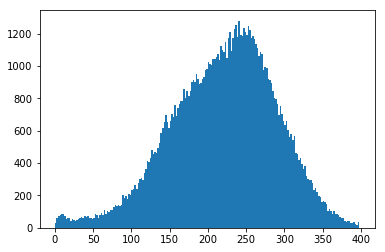

In [7]:
pwr = data['pwr'].astype(float)
pwr = pwr[~np.isnan(pwr)]
pwr = pwr[pwr > 0]
pwr = pwr[pwr < 500]
# pwr = pwr[]
h = plt.hist(pwr[::10], bins=np.arange(0, 400, 2))

In [ ]:
h[0][2]

In [ ]:
np.sum(pwr==2)

In [ ]:
((np.convolve(pwr, np.ones(30)/30.)**4).mean())**.25

## Elevation

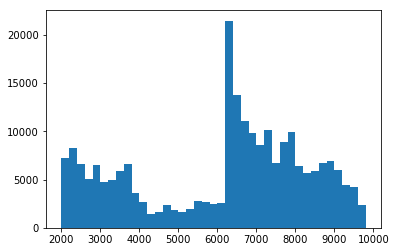

In [9]:
alt = data['alt'].astype(float)
alt = alt[~np.isnan(alt)]
alt = alt[alt > 2000/3.28]
_ = plt.hist(alt*3.28, bins=np.arange(2000, 10000, 200))

## Cadence

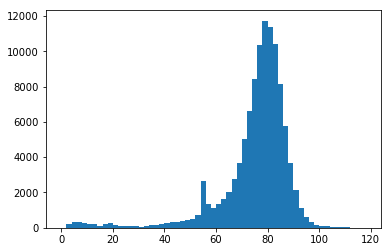

In [10]:
cad = data['cad'].astype(float)
cad = cad[~np.isnan(cad)]
cad = cad[cad > 0]
cad = cad[cad < 120]
_ = plt.hist(cad[::10], bins=np.arange(0, 120, 2))

In [ ]:
for c in np.arange(50, 60):
    print('%s: %s' % (c, np.sum(cad==c)))

## Heart rate

(40.0, 185.0)

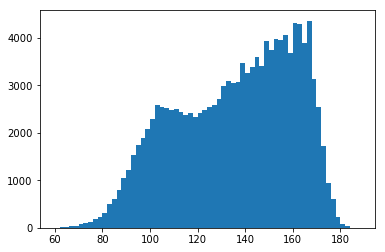

In [11]:
hrt = data['hrt'].astype(float)
hrt = hrt[~np.isnan(hrt)]
_ = plt.hist(hrt[::10], bins=np.arange(60, 190, 2))
hrt.min(), hrt.max()

In [ ]:
for h in np.arange(150, 170):
    print('%s: %s' % (h, np.sum(hrt==h)))

## Heart rate vs power

In [16]:
pwr = data['pwr'].astype(float)
hrt = data['hrt'].astype(float)

mk = (~np.isnan(pwr) & ~np.isnan(hrt))
pwr = pwr[mk]
hrt = hrt[mk]
mk = ((pwr > 0) & (pwr < 500))
pwr = pwr[mk]
hrt = hrt[mk]

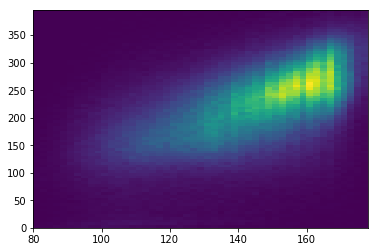

In [17]:
_ = plt.hist2d(hrt, pwr, bins=(np.arange(80,180, 2),np.arange(0, 400, 5)))

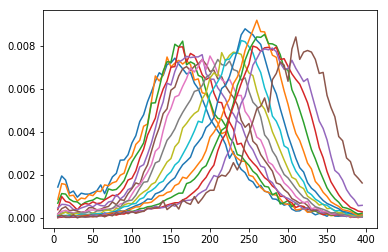

In [18]:
bins = np.arange(0, 400, 5)
hrt_bin_width = 5
hrt_bins = np.arange(100, 180, hrt_bin_width)
peaks = []
for hrt_bin in hrt_bins:
    h, b = np.histogram(pwr[((hrt > hrt_bin) & (hrt < (hrt_bin + hrt_bin_width)))], bins=bins, normed=True)
    plt.plot(bins[1:], h)
    
    peaks.append([hrt_bin, bins[np.argmax(h)]])

In [ ]:
peaks = np.array(peaks)
plt.plot(peaks[:,0], peaks[:,1])

In [ ]:
reg = stats.linregress(x=peaks[:,0], y=peaks[:,1])
print('slope: %s, pwr_0: %s' % (reg.slope, reg.intercept))
plt.plot(peaks[:,0], peaks[:,1])
plt.plot(np.arange(0, 200), reg.slope*np.arange(0, 200) + reg.intercept)

In [ ]:
print('HR at zero power: %s' % (-reg.intercept/reg.slope))
print('power at resting HR: %s' % (reg.slope * 48 + reg.intercept))

In [ ]:
hrt_bin_width = 2
hrt_bins = np.arange(120, 180, hrt_bin_width)
mean_power = []
for hrt_bin in hrt_bins:
    mean_power.append([hrt_bin, np.mean(pwr[((hrt > hrt_bin) & (hrt < (hrt_bin + hrt_bin_width)))])])
    
mean_power = np.array(mean_power)
reg = stats.linregress(x=mean_power[:,0], y=mean_power[:,1])
print('slope: %s, pwr_0: %s' % (reg.slope, reg.intercept))
plt.plot(mean_power[:,0], mean_power[:,1])
plt.plot(np.arange(100, 200), reg.slope*np.arange(100, 200) + reg.intercept)

print('HR at zero power: %s' % (-reg.intercept/reg.slope))
print('power at resting HR: %s' % (reg.slope * 48 + reg.intercept))

## Ride averages

In [ ]:
data_ = pd.DataFrame(data={'id': data['id'], 'pwr': data['pwr'], 'hrt': data['hrt']})
(data_.groupby('id').count()==0).pwr.sum()

In [ ]:
pwr_mean = []
hrt_mean = []
for id_, g in data_.groupby('id'):
    if np.any(~np.isnan(g.pwr.astype(float))):
        pwr_mean.append(g.pwr.mean())
        hrt_mean.append(g.hrt.mean())

In [ ]:
plt.scatter(hrt_mean, pwr_mean)

## Individual ride

In [ ]:
d = to_csv.gpx_to_csv(fnames[-1])

In [ ]:
vam = (3600/1.) * np.convolve(np.diff(d.alt), np.ones(60)/60., 'same')
plt.plot(vam)
plt.ylim([0,1600])

In [ ]:
_ = plt.hist(vam[vam>0], bins=100)

In [ ]:
_ = plt.hist(d.cad, bins=np.arange(40,120))

In [ ]:
# strava reports 4300ft
dalt = np.diff(d.alt)
np.sum(dalt[dalt > 0])*3.28

In [ ]:
np.ones(10)